In [26]:
"""
Script extracting wavenumbers, temperature, hot/cold status from temperature '.log' and raw spectra '.txt' files
"""

import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import math as m
import pandas as pd
import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [2]:
# VARIABLES
file_name = 'IC_raw_spectra_'

"""Polypropylene"""
path_raw = '//icnas4.cc.ic.ac.uk/rs5115/MSci Project/polypropylene' #path containing all raw spectra
full_log = 'poly_window_test1-20181218110622.log' #contains temperature and status of h/c BB target

"""After Realignment"""
#path_raw = 'D:/2018_11'
#full_log = '2018-11-28-20181128102247.log'

'After Realignment'

In [3]:
#FUNCTIONS

def read_file(directory, filename, separator, rowstoskip, head='infer'):
    """
    Reads an external file and outputs it as a Pandas Dataframe
    Input: Directory, Filename (Strings)
    Output: Pandas Dataframe
    """
    path=os.path.join(directory, filename)
    dataset = pd.read_csv(path, header = head, sep=separator, skiprows=rowstoskip)
    
    return dataset


def planck(wavenumber, temperature): # T in Kelvin, wavenumber in cm^-1
    """
    Calculates spectral radiance of a black body at some wavenumber and temperature
    Input: wavenumber (units: cm^{-1}), and temperature T (units: Kelvin) - (Integers or Floats)
    Output: spectral radiance (units: W m^{-2} sr^{-1} cm^{-1}) - (Float)
    """
    h = 6.626e-34
    c = 3.0e+8
    k = 1.381e-23

    planck_a = 2*h*(c**2)
    planck_e = h*c/k
    radiance = 100*planck_a*((wavenumber*100)**3)/(np.exp(planck_e*(wavenumber*100)/temperature)-1)

    return radiance


def read_raw_spectra(directory, filename):
    """
    Reads spectrum file and calculates the average of the 4 spectra
    Input: Directory, Filename (Strings)
    Output: average_spectrum (NumPy Array)
    """
    file_data = read_file(path_raw, filename, separator='  ', rowstoskip=5, head=None)
    spectrum1 = file_data[1].values
    spectrum2 = file_data[2].values
    spectrum3 = file_data[3].values
    spectrum4 = file_data[4].values
    average_spectrum = 0.25*(np.sum([spectrum1, spectrum2, spectrum3, spectrum4], axis=0))
    
    return average_spectrum

In [4]:
# CODE

#create list of file paths starting with file_name from 'path_raw' directory
measurements = len(glob.glob(path_raw + '/'+ file_name + '*')) #filepaths of all 'IC_raw_spectra' files
m_numbers = list(range(measurements)) #list of file name endings (integers)

for i in m_numbers:
    #checks that files have associated temperature measurements, and removes the files if not
    temp_check = read_file(path_raw, file_name + str(i) + '.txt', separator='  ', rowstoskip=None, head=None).iloc[1,0]
    if temp_check == 0.0:
        m_numbers.pop(i)
    
files = [file_name + str(num) + '.txt' for num in m_numbers] #final list of strings of file names, in order

c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


In [5]:
#times_df: Pandas DataFrame of dimensions (len(files)x4), containing spectra times as HH:MM:SS.millisec strings
times_df = pd.DataFrame(index=np.arange(0, len(files)), columns = ('time1','time2','time3','time4'))
read_times = np.array([]) #array of dimensions (len(files)x1). Each element is a string of 4 times

for i in np.arange(0, len(files)):
    #read times from each file and return read_times array. Replace row of times_df with the strings of time (split times by ' ')
    read_times = np.append(read_times, read_file(path_raw, files[i], separator = ',', rowstoskip=None, head=None).iloc[0].values)
    times_df.loc[i] = read_times[i].split()


spectrum_times = np.array([]) #array of dimensions (273*4 x 1), containing all spectra times in seconds from midnight format

for t in times_df.values.flatten():
    #times_df converted to 'spectrum_times' array, with new format (seconds from midnight)
    time = datetime.datetime.strptime(t, '%H:%M:%S.%f')
    spectrum_times = np.append(spectrum_times, time.microsecond/1000000 + time.second + time.minute*60 + time.hour*3600)

In [6]:
#Create 'log_file' Pandas DataFrame of the event log giving time, room temperature, cold blackbody (CBB) and hot blackbody (HBB) temperatures, and orientation (facing HBB or CBB)
raw_file = read_file(path_raw, full_log, separator=',', rowstoskip=None, head=None) #read log file
raw_file1 = raw_file[[1,6,8,9,10,11]].loc[raw_file[11] != 0] #select useful data outlined above; removing rows where 'Orientation'=0

log_file = raw_file1.reset_index(drop=True) #reset index to go from 0
log_file.columns = ['Real Time', 'room_temp', 'hbb_temp','cbb_temp','Time','Orientation'] #all the column names
log_file['hc'] = np.nan #add empty 'hc' column

log_file.loc[log_file['Orientation'] == 270, 'hc'] = 'h' #if Orientation=270, 'h' (facing HBB)
log_file.loc[log_file['Orientation'] == 225, 'hc'] = 'c' #if Orientation=225, 'c' (facing CBB)


times = spectrum_times[0::4] #start times of each 4 spectra in one file
log_length = log_file.shape[0] #length of the log_file

for i in np.arange(0,len(times)):
    #add (len(files)) empty rows log_file DataFrame, and insert 'times' into the new rows with empty 'Time' columns, leaving 'NaN' in all other columns
    log_file.loc[log_length+i]= np.nan
    log_file.loc[log_length+i, 'Time'] = times[i]

log_file = log_file.sort_values('Time') #sort log_file DataFrame into order based on 'Time' column (inserts the spectra times in order)
log_file = log_file.reset_index(drop=True)

In [7]:
#Create 'spectra_log' Pandas DataFrame with start time of measured spectra, their h/c status, average temperature, and temperature standard deviation
hc_list = [] #list of 'h' or 'c' values associated with the spectra
temps_avg = [] #list of average temperatures over each spectrum
temps_std = [] #list of temperature standard deviations over each spectrum

d = log_file.index[-1] #last index of log_file
while log_file.at[d, 'hc'] == 'c' or log_file.at[d, 'hc'] == 'h':
    #search through rows from end to beginning in log_file to search for rows without an associated 'hc' value
    d -=1

for i in range(d-1):
    #assign 'h' or 'c' values for the hc column of log_file for the spectra (which currently only have a 'Time'), based on the value of the next h/c in the list
    value = log_file.at[i, 'hc']
    if value != 'c' and value != 'h': #value in 'hc' column neither h/c (locate spectra)
        hot_or_cold = log_file.iloc[i+1]['hc']
        hc_list.append(hot_or_cold) # the spectra are assigned the h_c value of the following time
        temp_list = []
        a=2
        if hot_or_cold == 'h':
            #if spectrum is hot, find its avg. temp. using temperatures in the 'hbb_temp' column of the next rows until the start of the next spectrum
            num = log_file.iloc[i+1]['hbb_temp']
            while m.isnan(num) == False:
                temp_list.append(num)
                num = log_file.iloc[i+a]['hbb_temp']
                a += 1
            temps_avg.append(np.average(temp_list))
            temps_std.append(np.std(temp_list)) #standard deviation of temperatures used to calculate temperature of the spectrum
        elif hot_or_cold == 'c':
            #if spectrum is cold, use same procedure but with temperatures from the 'cbb_temp' column
            num = log_file.iloc[i+1]['cbb_temp']
            while m.isnan(num) == False:
                temp_list.append(num)
                num = log_file.iloc[i+a]['cbb_temp']
                a += 1
            temps_avg.append(np.average(temp_list))
            temps_std.append(np.std(temp_list))


final_frame_4 = pd.DataFrame(
    {'Time': times[:-1],
     'h_or_c': hc_list,
     'temp_avg': temps_avg,
     'temp_std': temps_std
    })

In [8]:
wavenums = read_file(path_raw, files[0], separator='  ', rowstoskip=5, head=None)[0].values #NumPy array of the spectral range (units: cm^{-1})
average_4_spectra = [] #all spectra

for f in files:
    average_4_spectra.append(read_raw_spectra(path_raw, f))

c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


In [9]:
def response_fn(spectrum_number): #returns the response function at some time and wavenumber
    
    (a,b) = (average_4_spectra[spectrum_number], average_4_spectra[spectrum_number + 1])
    if a[1000] < b[1000]:
        V_c = a
        V_h = b
    else:
        V_c = b
        V_h = a
        
    V_diff = np.array(V_h)-np.array(V_c)
    
    (e,f) = (final_frame_4.at[spectrum_number,'temp_avg'], final_frame_4.at[spectrum_number+1,'temp_avg'])
   # +1 and +2 are ad hoc to make the code work!!!!
    if e<f:
        temp_average_c = e
        temp_average_h = f
    else:
        temp_average_c = f
        temp_average_h = e

    radiances_avg_h = [planck(wn, temp_average_h+273.15) for wn in wavenums]
    radiances_avg_c = [planck(wn, temp_average_c+273.15) for wn in wavenums]
    rad_diff = np.array(radiances_avg_h) - np.array(radiances_avg_c)
    
    def division(raw_val,planck_val):
        if planck_val == 0:
            div = 0
        else:
            div = raw_val/planck_val
        return div
    
    division_vec = np.vectorize(division)
    ratio = division_vec(V_diff, rad_diff)
    
    return(ratio)

In [10]:
indices = np.arange(1, len(average_4_spectra)-2, 2)     #array of every other (odd) index, starting at n=1, cold
all_resp_functions = [response_fn(i) for i in indices]  #list of arrays of response functions available to plot, list length=175, array lengths=4001

diff_resp_functions = [i - all_resp_functions[-1] for i in np.array(all_resp_functions)]

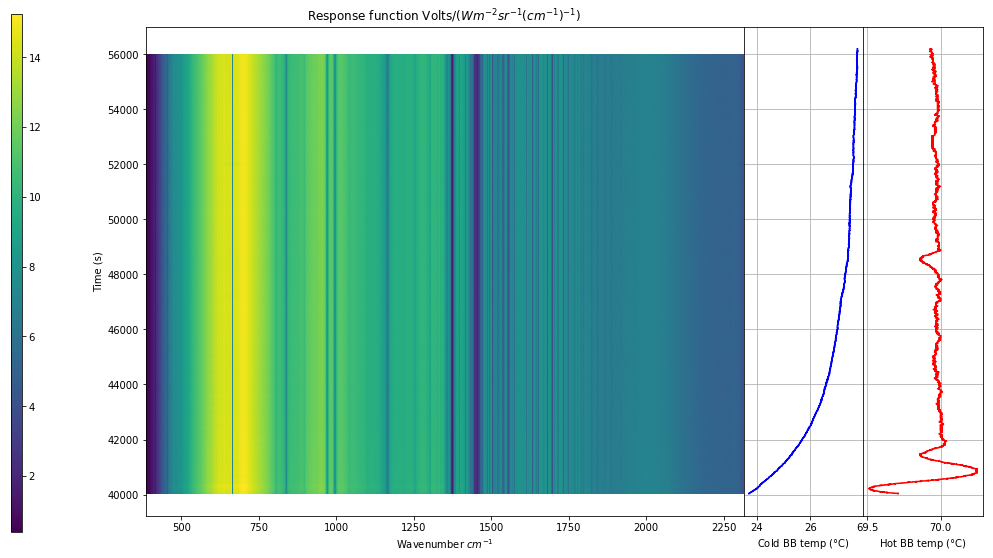

In [11]:
grid = plt.GridSpec(1, 7, wspace=0)

fig = plt.figure(figsize=(15,9))

ax1 = fig.add_subplot(grid[0,:5])
p = ax1.pcolor(wavenums, times[:-2:2], all_resp_functions)
plt.title('Response function Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)')
plt.xlabel('Wavenumber $cm^{-1}$')
plt.ylabel('Time (s)')
cbaxes = fig.add_axes([0, 0.1, 0.01, .8]) 
cb = fig.colorbar(p, cax = cbaxes)

ax2 = fig.add_subplot(grid[0,5:6], sharey = ax1)
ax2.plot(log_file['cbb_temp'], log_file['Time'], 'b')
plt.grid()
plt.xlabel('Cold BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

ax3 = fig.add_subplot(grid[0,6:7], sharey = ax1)
ax3.plot(log_file['hbb_temp'], log_file['Time'], 'r')
plt.grid()
plt.xlabel('Hot BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

plt.show()

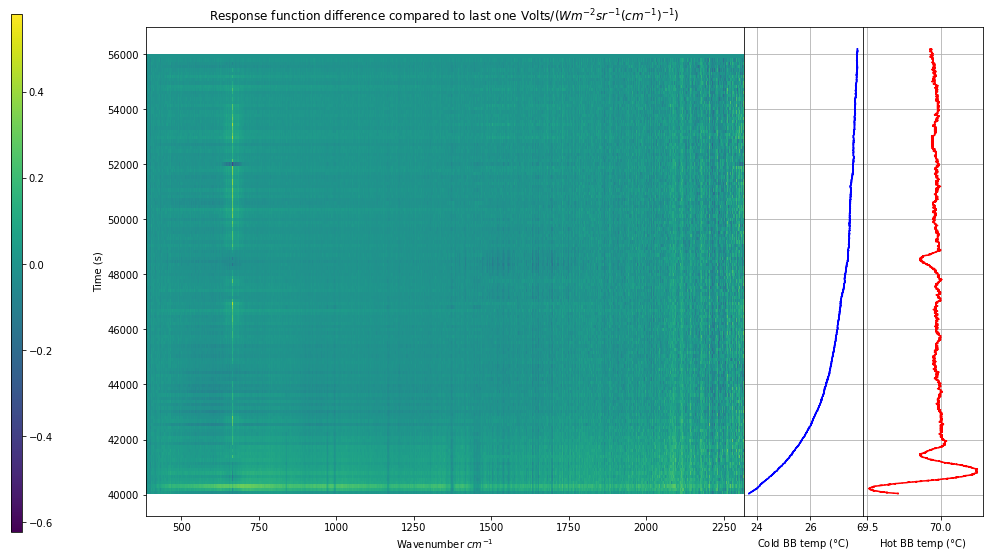

In [12]:
grid = plt.GridSpec(1, 7, wspace=0)

fig = plt.figure(figsize=(15,9))

ax1 = fig.add_subplot(grid[0,:5])
p = ax1.pcolor(wavenums, times[:-2:2], diff_resp_functions)
plt.title('Response function difference compared to last one Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)')
plt.xlabel('Wavenumber $cm^{-1}$')
plt.ylabel('Time (s)')
cbaxes = fig.add_axes([0, 0.1, 0.01, .8]) 
cb = fig.colorbar(p, cax = cbaxes)

ax2 = fig.add_subplot(grid[0,5:6], sharey = ax1)
ax2.plot(log_file['cbb_temp'], log_file['Time'], 'b')
plt.grid()
plt.xlabel('Cold BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

ax3 = fig.add_subplot(grid[0,6:7], sharey = ax1)
ax3.plot(log_file['hbb_temp'], log_file['Time'], 'r')
plt.grid()
plt.xlabel('Hot BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

plt.show()

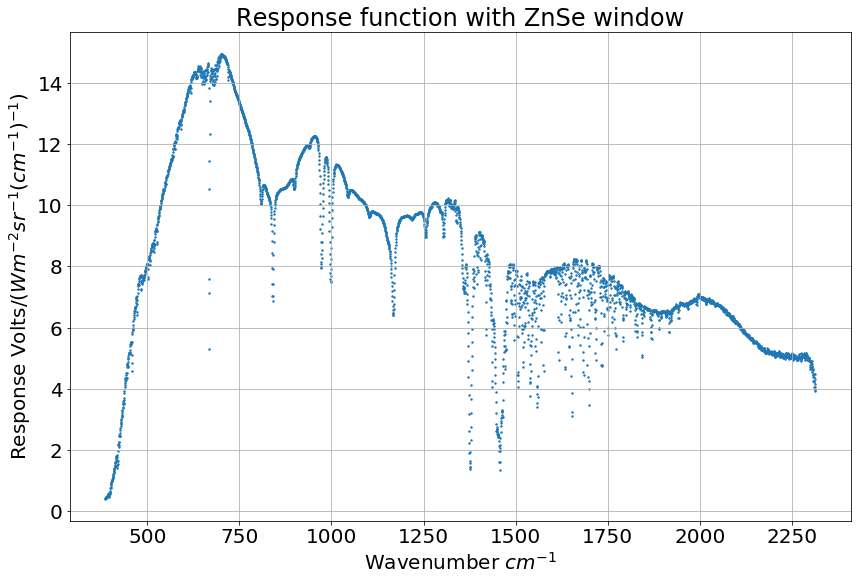

In [13]:
def plot_resp_wn(n):
    fig = plt.figure(figsize=(14,9))
    plt.scatter(wavenums, all_resp_functions[n], s=2)
    plt.title('Response function with ZnSe window', fontsize=24) #  for spectrum {}'.format(n)
    plt.xlabel('Wavenumber $cm^{-1}$', fontsize=20)
    plt.ylabel('Response Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)', fontsize=20)
    plt.tick_params(labelsize=20, labelcolor='black')
    plt.grid()
    #fig.savefig('Graphs/Sample_resp_function_ZnSe.png', dpi=600)
    plt.show()

fig = plot_resp_wn(len(all_resp_functions)-1)

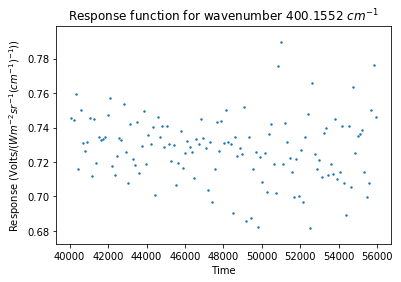

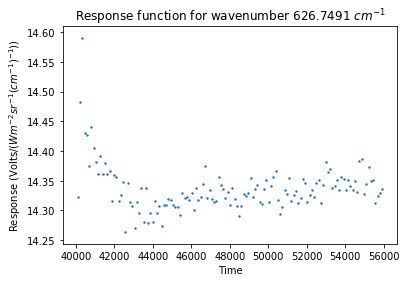

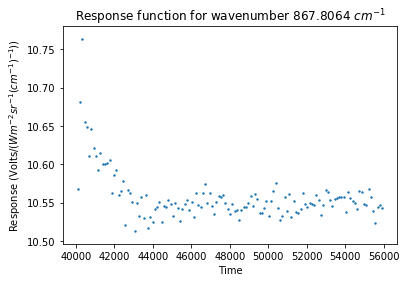

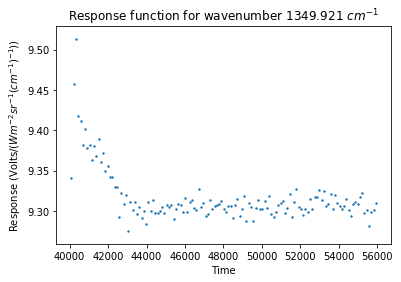

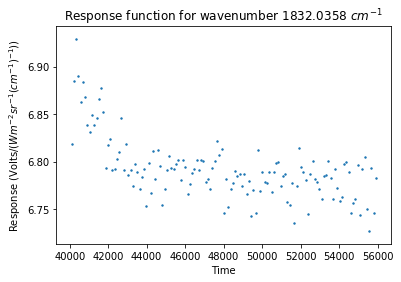

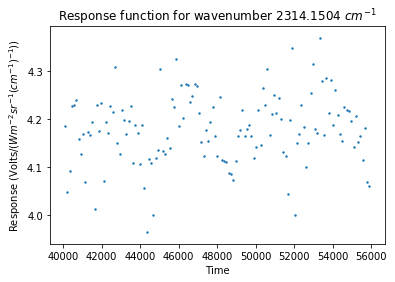

In [14]:
def plot_resp_time(n):
    plt.scatter(times[1:-2:2], [i[n] for i in all_resp_functions], s=2)
    plt.title('Response function for wavenumber ' + str(wavenums[n]) + ' $cm^{-1}$')
    plt.xlabel('Time')
    plt.ylabel('Response (Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$))')
    plt.show()

plot_resp_time(30)
plot_resp_time(500)
plot_resp_time(1000)
plot_resp_time(2000)
plot_resp_time(3000)
plot_resp_time(4000)

In [15]:
def finding_std_dev(spec_num): #fractional std dev of response function based on standard dev of temperatures recorded during the spectrum- may need to realign lengths of "average_4_spectra" and "final_frame_4" so they align

    (a,b,c,d) = (final_frame_4.at[spec_num,'temp_avg'], final_frame_4.at[spec_num+1,'temp_avg'], final_frame_4.at[spec_num,'temp_std'], final_frame_4.at[spec_num+1,'temp_std'])
    if a<b:
        T_c = a
        T_h = b
        std_dev_Tc = c
        std_dev_Th = d
    else:
        T_c = b
        T_h = a
        std_dev_Tc = d
        std_dev_Th = c

    L_h = [planck(wn, T_h+273.15) for wn in wavenums] #radiance of HBB @ spec_num or spec_num+1
    L_h_plus = [planck(wn, T_h+273.15+std_dev_Th) for wn in wavenums] #spectrum of radiance + 1 std dev of radiance of HBB
    L_h_std = np.array(L_h_plus) - np.array(L_h) #spectrum of radiance std dev of HBB
    
    L_c = [planck(wn, T_c+273.15) for wn in wavenums] #radiance curve of CBB @ spec_num or spec_num+1
    L_c_plus = [planck(wn, T_c+273.15+std_dev_Tc) for wn in wavenums] #spectrum of radiance + 1 std dev of radiance of CBB
    L_c_std = np.array(L_c_plus) - np.array(L_c)
    
    L_diff = np.array(L_h) - np.array(L_c)
    term2 = 1/(L_diff**2)                    
    term3 = np.sqrt(L_h_std**2 + L_c_std**2) 
    
    (e,f) = (average_4_spectra[spec_num], average_4_spectra[spec_num + 1])
    if e[1000] < f[1000]:
        V_c = e
        V_h = f
    else:
        V_c = f
        V_h = e
    V_diff = np.array(V_h)-np.array(V_c) #term1
    
    std_dev_resp_fn = V_diff * term2 * term3
    resp_fn = [i/j for (i,j) in zip(V_diff, L_diff)]
    perc_std_dev = [i*100/j for (i,j) in zip(std_dev_resp_fn, resp_fn)]
    
    return(perc_std_dev)

In [16]:
all_stand_devs = [finding_std_dev(spec) for spec in np.arange(1,len(times)-2, 2)]

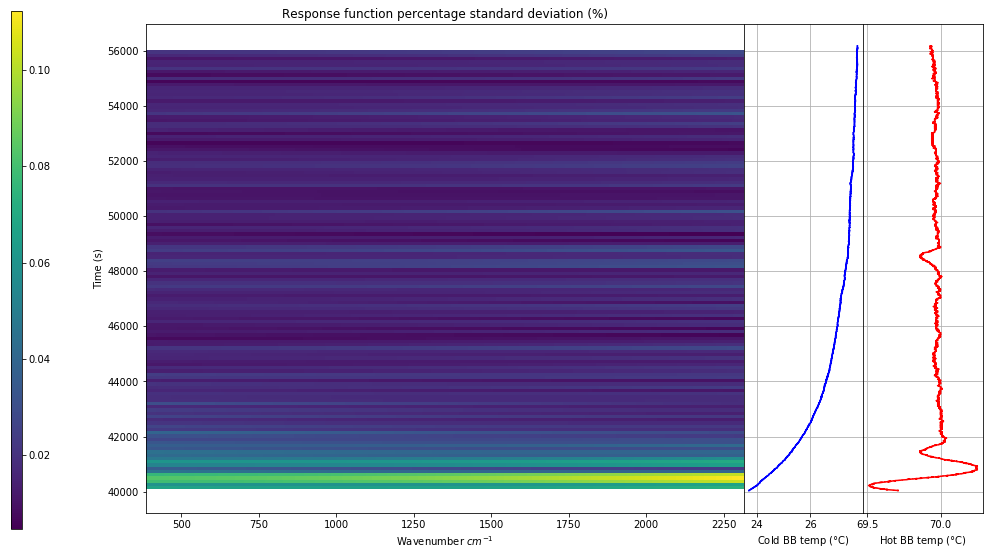

In [17]:
grid = plt.GridSpec(1, 7, wspace=0)

fig = plt.figure(figsize=(15,9))

ax1 = fig.add_subplot(grid[0,:5])
q = ax1.pcolor(wavenums, times[1::2], all_stand_devs)
plt.title('Response function percentage standard deviation (%)')
plt.xlabel('Wavenumber $cm^{-1}$')
plt.ylabel('Time (s)')
cbaxes = fig.add_axes([0, 0.1, 0.01, .8]) 
cb = fig.colorbar(q, cax = cbaxes)

ax2 = fig.add_subplot(grid[0,5:6], sharey = ax1)
ax2.plot(log_file['cbb_temp'], log_file['Time'], 'b')
plt.grid()
plt.xlabel('Cold BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

ax3 = fig.add_subplot(grid[0,6:7], sharey = ax1)
ax3.plot(log_file['hbb_temp'], log_file['Time'], 'r')
plt.grid()
plt.xlabel('Hot BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)


plt.show()

In [18]:
def resp_from_end(wn): #there are two responses per wn
    wavenumber = wavenums[(wn-386)*2]
    wn_responses = [all_resp_functions[i][(wn-386)*2] for i in range(len(all_resp_functions))]
    # [(wn-386)*2] was [wn*2], but I think now it's correct. Unfortunately the graphs aren't as nice as before :(
    
    #start taking the last 10 values and expand
    stds_from_back = [np.std(wn_responses[-10-i:-1]) for i in range(0, len(wn_responses)-10)]
    avgs_from_back = [np.average(wn_responses[-10-i:-1]) for i in range(0, len(wn_responses)-10)]
    fractional_stds_from_back = [a/b*100 for (a,b) in zip(stds_from_back,avgs_from_back)] #in percent
    
    return(stds_from_back, avgs_from_back, fractional_stds_from_back, wavenumber)

No handles with labels found to put in legend.


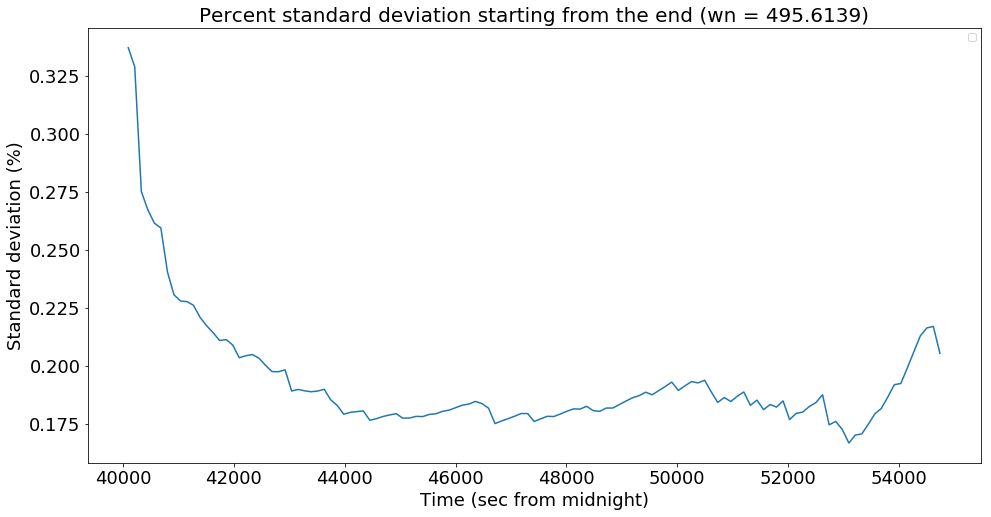

In [19]:
stds_from_back, avgs_from_back, fractional_stds_from_back, wavenumber = resp_from_end(500)
fig = plt.figure(figsize=(16, 8))
plt.plot(times[1:-22:2], fractional_stds_from_back[::-1])
plt.title('Percent standard deviation starting from the end (wn = {})'.format(wavenumber), fontsize=20)
plt.xlabel('Time (sec from midnight)', fontsize=18)
plt.ylabel('Standard deviation (%)', fontsize=18)
plt.legend()
plt.tick_params(labelsize=18, labelcolor='black')
#fig.savefig('Graphs/Percentage_rep_function_std_from_end.png', dpi=600)
plt.show()

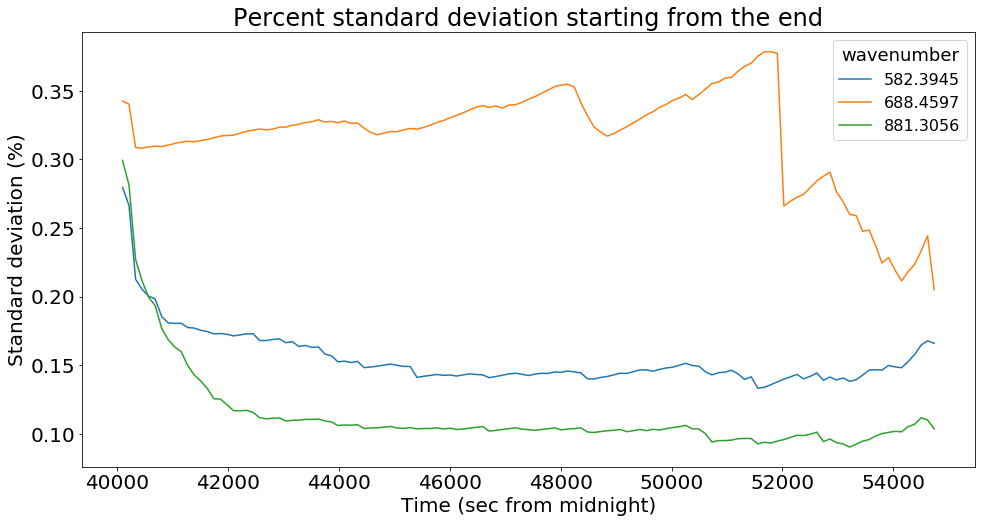

In [20]:
stds_from_back, avgs_from_back, fractional_stds_from_back, wavenumber = resp_from_end(590)
stds_from_back1, avgs_from_back1, fractional_stds_from_back1, wavenumber1 = resp_from_end(700)
stds_from_back2, avgs_from_back2, fractional_stds_from_back2, wavenumber2 = resp_from_end(900)


fig = plt.figure(figsize=(16, 8))
plt.plot(times[1:-22:2], fractional_stds_from_back[::-1])
plt.plot(times[1:-22:2], fractional_stds_from_back1[::-1])
plt.plot(times[1:-22:2], fractional_stds_from_back2[::-1])
plt.title('Percent standard deviation starting from the end', fontsize=24)
plt.xlabel('Time (sec from midnight)', fontsize=20)
plt.ylabel('Standard deviation (%)', fontsize=20)
legend = plt.legend([wavenumber, wavenumber1, wavenumber2], title='wavenumber', fontsize=16)
plt.setp(legend.get_title(), fontsize = 18)
plt.tick_params(labelsize=20, labelcolor='black')
#fig.savefig('Graphs/Percentage_rep_function_std_from_end_all.png', dpi=600)
plt.show()

In [21]:
all_stds_from_back = []

for wn in wavenums[:1890]: #this is up to wn of 1250
    stds_from_back, avgs_from_back, fractional_stds_from_back, wavenumber = resp_from_end(int(np.floor(wn)))
    all_stds_from_back.append(np.array(fractional_stds_from_back))

In [22]:
wavenums[:1890]
wavenums_plot = []

for wn in wavenums[:1890]:
    wavenums_plot.append([wn] * (len(times[1:-2:2])-10))
flat_wns = [item for sublist in wavenums_plot for item in sublist]

236250


In [23]:
times_plot = list(times[1:-2:2])[::-1][:-10]
flat_times = [item for sublist in [times_plot]*len(wavenums[:1890]) for item in sublist]

236250


In [24]:
flat_stds = [item for sublist in all_stds_from_back for item in sublist]
len(flat_stds)

236250


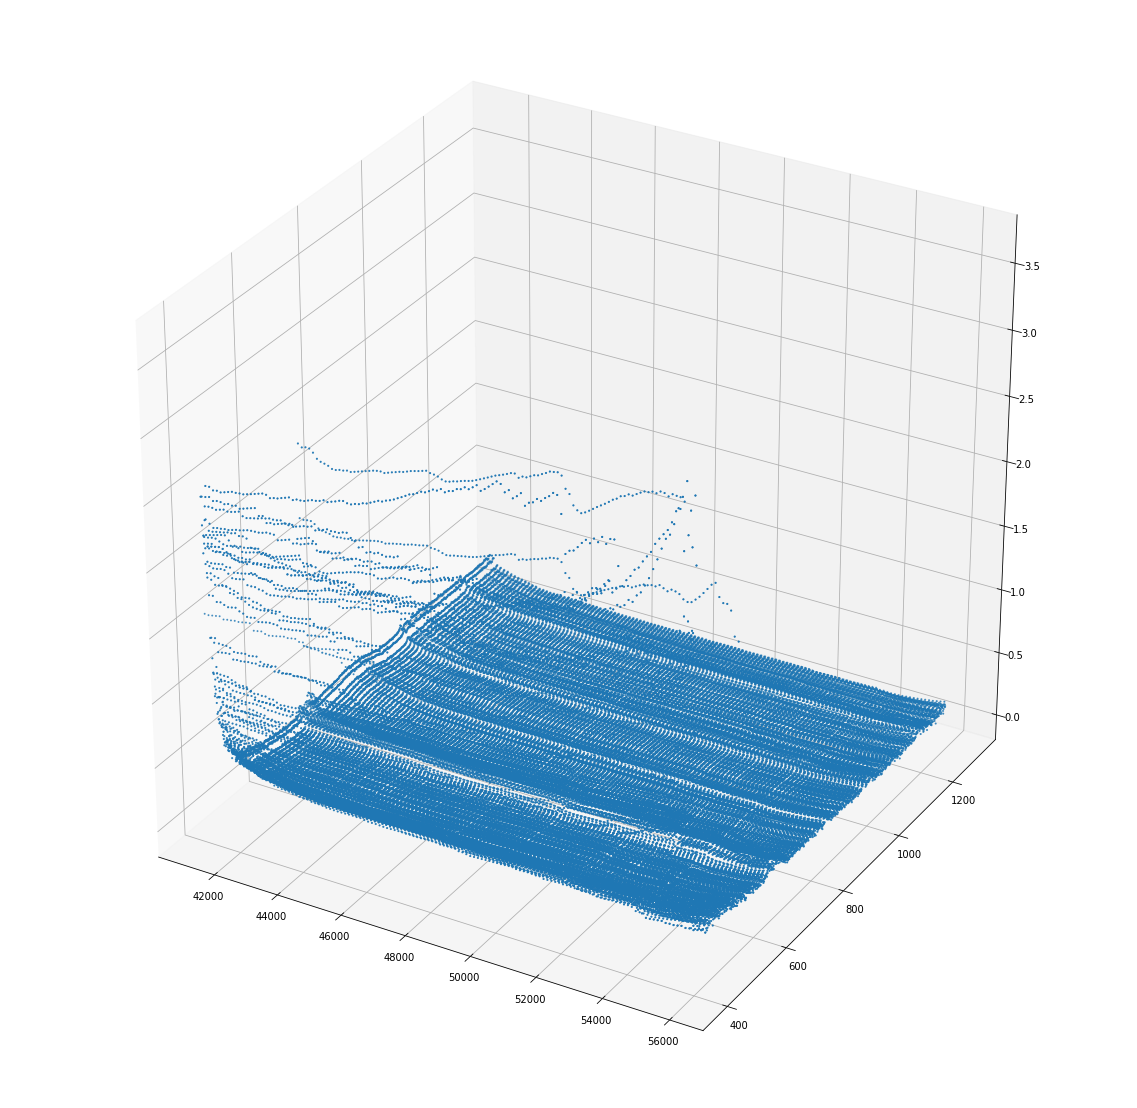

In [27]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(flat_times, flat_wns, flat_stds, s=1, cmap='inferno')
plt.show()

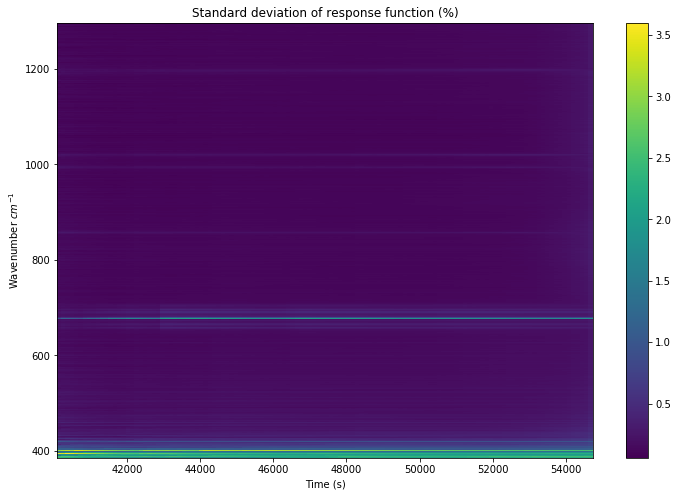

In [31]:
fig, ax = plt.subplots(figsize=(12,8))

p = ax.pcolor(times[1:-22:2], wavenums[:1890], all_stds_from_back)
cb = fig.colorbar(p)
plt.title(r'Standard deviation of response function (%)')
plt.ylabel('Wavenumber $cm^{-1}$')
plt.xlabel('Time (s)')
plt.show()